In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# fix macos n_job>1 bugs
import multiprocessing
multiprocessing.set_start_method('forkserver')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load local python scripts.

In [2]:
#plot model evaluation metrics
from plotting import *

#data exploration functions
from data_exploration import *

#data pre-processing functions
from pre_processing import *

#classifiers and cross-validation
from classifiers import *

##  Dataset
Load data from disk and store as pandas dataframe.

In [3]:
#data sets
DATA_PATH = 'dataset/'
OUTPUT_PATH = None
FILE_NAME = 'city_search.json'

In [4]:
df = pd.read_json(DATA_PATH+FILE_NAME)
df['session_id'] = df.session_id.map(lambda x:x[0])
df['unix_timestamp'] = df.unix_timestamp.map(lambda x:x[0])
df['cities'] = df.cities.map(lambda x:x[0])
df['len'] = df.cities.map(lambda x:len(x.split(',')))
df['user_id'] = df.user.map(lambda x:x[0][0]['user_id'])
df['joining_date'] = df.user.map(lambda x:x[0][0]['joining_date'])
df['country'] = df.user.map(lambda x:x[0][0]['country'])
df = df.drop('user',axis=1)
df = df.replace({'' : 'UNK'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   session_id      20022 non-null  object
 1   unix_timestamp  20022 non-null  int64 
 2   cities          20022 non-null  object
 3   len             20022 non-null  int64 
 4   user_id         20022 non-null  int64 
 5   joining_date    20022 non-null  object
 6   country         20022 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


Users have unique country.

In [6]:
non_missing = df[df.country!=''].user_id.to_list()
missing = df[df.country==''].user_id.to_list()
overlap = [m for m in missing if m in non_missing]
print(len(overlap))

0


Treat each country as a different feature, flatten data into one-hot vector.

In [7]:
all_city_names = set()
for row in df.cities.to_list():
    names = row.split(', ')
    for name in names:
        all_city_names.add(name)

all_city_names = sorted(list(all_city_names))
new_rows = np.zeros((df.shape[0],len(all_city_names)))

for i,row in enumerate(df.cities.to_list()):
    names = row.split(', ')
    for name in names:
        index = all_city_names.index(name)
        new_rows[i,index] = 1

df_one_hot = pd.DataFrame(new_rows, columns=all_city_names)
df_one_hot['user_id'] = df.user_id
df_one_hot['joining_date'] = df.joining_date
df_one_hot['country'] = df.country

## Task 2

### 2.1 Frequent Itemset
Find frequent itemset among all search sessions using Aprior, predict next search city based on assosiation rules with confidence.

In [8]:
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

df2 = df[df.len>1]
df3 = df[df.len>2]
df4 = df[df.len>3]

dataset = [c.split(', ')for c in df4.cities.to_list()]
print(len(dataset))

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
te_df = pd.DataFrame(te_ary, columns=te.columns_)

826


In [9]:
frequent_itemsets = apriori(te_df, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.110169,(Anaheim CA)
1,0.053269,(Arlington TX)
2,0.061743,(Austin TX)
3,0.012107,(Bakersfield CA)
4,0.123487,(Baltimore MD)
...,...,...
527,0.010896,"(Los Angeles CA, Santa Ana CA, San Diego CA, L..."
528,0.025424,"(Baltimore MD, Newark NJ, Jersey City NJ, New ..."
529,0.012107,"(Baltimore MD, Newark NJ, New York NY, WASHING..."
530,0.012107,"(Oshawa ON, Toronto ON, Saint Catharines-Niaga..."


In [10]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)

In [11]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Long Beach CA),(Anaheim CA),0.096852,0.110169,0.070218,0.725000,6.580769,0.059548,3.235747
1,(Anaheim CA),(Long Beach CA),0.110169,0.096852,0.070218,0.637363,6.580769,0.059548,2.490498
2,(Anaheim CA),(Los Angeles CA),0.110169,0.133172,0.087167,0.791209,5.941259,0.072496,4.151650
3,(Los Angeles CA),(Anaheim CA),0.133172,0.110169,0.087167,0.654545,5.941259,0.072496,2.575825
4,(Anaheim CA),(Riverside CA),0.110169,0.088378,0.069007,0.626374,7.087460,0.059271,2.439930
...,...,...,...,...,...,...,...,...,...
2681,(Oshawa ON),"(OTTAWA ON, Montreal QC, Saint Catharines-Niag...",0.118644,0.015738,0.010896,0.091837,5.835165,0.009029,1.083794
2682,(Montreal QC),"(OTTAWA ON, Saint Catharines-Niagara ON, Toron...",0.107748,0.016949,0.010896,0.101124,5.966292,0.009070,1.093644
2683,(Toronto ON),"(OTTAWA ON, Montreal QC, Saint Catharines-Niag...",0.159806,0.014528,0.010896,0.068182,4.693182,0.008574,1.057580
2684,(OTTAWA ON),"(Montreal QC, Saint Catharines-Niagara ON, Tor...",0.064165,0.015738,0.010896,0.169811,10.789550,0.009886,1.185588


Make prediction by looking for frequent itemset in training set.

In [12]:
def random_query_itemset(rules):
    query = set()
    prev = np.random.randint(1,3)
    for i in range(prev):
        query.add(np.random.choice(all_city_names))
    print('Query:', query)
    return rules[rules['antecedents'] == frozenset(query)].sort_values(by=['confidence'],ascending=False).iloc[:5,:]

In [83]:
%time
random_query_itemset(rules)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Query: {'Seattle WA', 'Portland OR'}


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1505,"(Seattle WA, Portland OR)",(Vancouver BC),0.044794,0.082324,0.039952,0.891892,10.833863,0.036264,8.488499
1511,"(Seattle WA, Portland OR)",(Victoria BC),0.044794,0.077482,0.033898,0.756757,9.766892,0.030428,3.792575
2498,"(Seattle WA, Portland OR)","(Victoria BC, Vancouver BC)",0.044794,0.070218,0.030266,0.675676,9.622554,0.027121,2.866828
832,"(Seattle WA, Portland OR)",(Calgary AB),0.044794,0.054479,0.018160,0.405405,7.441441,0.015719,1.590194
1091,"(Seattle WA, Portland OR)",(Edmonton AB),0.044794,0.044794,0.013317,0.297297,6.636961,0.011311,1.359331


### 2.2 Language Model
Build a language model based on sequence of city names, try to find the pattern inside the search sequence.

In [14]:
import torch
from torch import nn
from torch.nn import Linear, ReLU, Sequential
import torch.optim as optim

In [15]:
import sys
sys.path.append('./word_language_model')

#### Prepare data

In [16]:
def save_files(cities, file_name):
    import os
    file_path = './word_language_model/data/city/'
    if not os.path.exists(os.path.dirname(file_path)):
        try:
            os.makedirs(os.path.dirname(file_path))
        except:
            pass
    with open(file_path+file_name,'w') as f:
        for c in cities:
            row = ', '.join(c.split(', ')[:-1]+c.split(',')[-1:])+',\n'
            f.write(row)

In [17]:
cities = df[df.len>=3].cities.to_list()
train,test = train_test_split(cities, test_size=0.3, random_state=0)
train,valid = train_test_split(train, test_size=0.1, random_state=0)

In [18]:
save_files(train,'train.txt')
save_files(valid,'valid.txt')
save_files(test,'test.txt')

#### Train model
Load data from disk, save final model back to disk.

In [19]:
# !python word_language_model/main.py \
# --data './word_language_model/data/city' --save './word_language_model/model.pt' \
# --emsize 650 --nhid 650 --dropout 0.5 --epochs 12 --tied

!python word_language_model/main.py \
--data './word_language_model/data/city' \
--save './word_language_model/model.pt' --epochs 15

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.60s | valid loss  4.20 | valid perplexity    66.78
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  1.60s | valid loss  3.53 | valid perplexity    34.13
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  1.68s | valid loss  2.33 | valid perplexity    10.26
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  1.66s | valid loss  1.63 | valid perplexity     5.09
----------------------------------------------

#### Predict next city
Load trained model to predict next city based on the given sequence of cities.


In [20]:
test_lines = None
train_lines = None

with open('./word_language_model/data/city/test.txt') as f:
    test_lines = f.readlines()
    
with open('./word_language_model/data/city/train.txt') as f:
    train_lines = f.readlines()    

In [21]:
import data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('./word_language_model/model.pt', 'rb') as f:
    model = torch.load(f).to(device)
model.eval()

corpus = data.Corpus('./word_language_model/data/city')
ntokens = len(corpus.dictionary)

In [22]:
def predict_last_city(given_cities):    
    hidden = model.init_hidden(1)
    input = None
    next_city = []

    with torch.no_grad():
        for p in given_cities[:-1]:
            index = corpus.dictionary.word2idx[p]
            input = torch.randint(index,index+1, (1, 1), dtype=torch.long).to(device)
            _, hidden = model(input, hidden)
            
        index = corpus.dictionary.word2idx[given_cities[-1]]
        input = torch.randint(index,index+1, (1, 1), dtype=torch.long).to(device)            
        while True:
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(1.0).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]
            if word == '<eos>':
                if len(next_city)==0:
                    continue
                else:
                    break
            next_city.append(word)
                
        return next_city

def random_query(lines):
    line = np.random.choice(lines)
    query = line.split('  ')[0].split()
    true = line.split('  ')[-1][:-1]
    pred = ' '.join(predict_last_city(query))
    print('Previous:',' '.join(query))
    print('     =',true)
    print('     >',pred)
#     print(true in pred)

In [92]:
random_query(train_lines)
random_query(train_lines)
random_query(train_lines)
print()
random_query(test_lines)
random_query(test_lines)
random_query(test_lines)

Previous: New York NY, Jersey City NJ,
     = Newark NJ,
     > Newark NJ,
Previous: New York NY, Baltimore MD, WASHINGTON DC,
     = Philadelphia PA,
     > Chicago IL, Milwaukee WI, Fort Wayne IN,
Previous: Houston TX, Dallas TX,
     = Austin TX,
     > Plano TX,

Previous: Dallas TX, Arlington TX,
     = Fort Worth TX,
     > Dallas TX, Austin TX, Fort Worth TX,
Previous: New York NY, Jersey City NJ,
     = Newark NJ,
     > Los Angeles CA, Toronto ON, New York NY,
Previous: Calgary AB, Edmonton AB, Vancouver BC, Seattle WA,
     = Victoria BC,
     > Toronto ON, Hamilton ON, Saint Catharines-Niagara ON, Hamilton ON,


#### Generate city sequence
This model could also generate sequence of cities from the first city.

In [24]:
def generate_from_first(given_cities):
    total_words = len(given_cities)
    
    first_word = given_cities[0]
    index = corpus.dictionary.word2idx[first_word]
    input = torch.randint(index,index+1, (1, 1), dtype=torch.long).to(device)
    hidden = model.init_hidden(1)

    output_words = []
    output_words.append(first_word)
    
    with torch.no_grad():
        while len(output_words)<total_words:
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(1.0).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]
            if word!='<eos>':
                output_words.append(word)
    return output_words

def random_generate(lines):
    line = np.random.choice(lines)
    query = line.split('  ')[0].split()
    first_word = query[0]
    pred = generate_from_first(query)
    print('Start:',first_word)
    print('     =',' '.join(query))
    print('     >',' '.join(pred))

In [94]:
random_generate(train_lines)
random_generate(train_lines)
random_generate(train_lines)
print()
random_generate(test_lines)
random_generate(test_lines)
random_generate(test_lines)

Start: Vancouver
     = Vancouver BC, Victoria BC,
     > Vancouver BC, New York
Start: Chicago
     = Chicago IL, Fort Wayne IN,
     > Chicago IL, Houston TX, Fort
Start: Montreal
     = Montreal QC, OTTAWA ON, Toronto ON, Oshawa ON,
     > Montreal QC, New York NY, Newark NJ, Philadelphia

Start: Philadelphia
     = Philadelphia PA, Montreal QC,
     > Philadelphia PA, San Antonio
Start: Calgary
     = Calgary AB, Portland OR, Vancouver BC,
     > Calgary AB, Calgary AB, New York
Start: Chicago
     = Chicago IL, Indianapolis IN, Lexington KY,
     > Chicago IL, Houston TX, Austin TX,


#### Evaluation

##### Perplexity
This model was trained by minimizing perplexity(cross entropy), the final results was showed above.

##### Accuracy

In [26]:
total = 0
correct = 0

# target = train_lines
target = test_lines

for line in target:
    query = line.split('  ')[0].split()
    true = line.split('  ')[-1][:-1]
    pred = ' '.join(predict_last_city(query))
    if true in pred:
        correct += 1
    total +=1
#     if total % (len(target)//5)==0:
#         print(total)
acc = correct*100.0 / total
print('Accuracy:%.2f%%' % acc)

Accuracy:17.30%


### 2.3 Neural Machine Translation

Treat this task as a translation task, the system translate the given sequence of search cities to another city/cities.

In [8]:
from neural_machine_translation import *

#### Prepare data

In [9]:
def get_city_pairs(df_tar):
    with open('prev_city-next_city.txt','w') as f:
        for city in df_tar.cities.to_list():
            city_pair = city.split(', ')
            row = city_pair
            row = ' '.join(row[:-1])+'\t'+row[-1]+'\n'      
            f.write(row)
    return prepareData('prev_city', 'next_city')

In [10]:
df

,session_id,unix_timestamp,cities,len,user_id,joining_date,country
0,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2,2024,2015-03-22,UK
1,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",3,2853,2015-03-28,DE
2,SHTB4IYAX4PX6,1440843490,San Antonio TX,1,10958,2015-03-06,UK
3,JBRB8MZGTX3M4,1427268063,Edmonton AB,1,7693,2015-03-12,IT
4,YJCMPURC2FL9C,1430559067,"Phoenix AZ, Houston TX",2,7506,2015-02-28,UK
...,...,...,...,...,...,...,...
20017,17WJGZOEFEI4W,1430545204,"Chicago IL, Montreal QC",2,4360,2015-03-21,UNK
20018,9HCZDQMGU5Z2G,1434444360,Chicago IL,1,2057,2015-03-22,IT
20019,73ZWORX75Y9A0,1438584470,Chicago IL,1,1203,2015-02-28,IT
20020,DMWGV9HY74G9T,1435235491,"Calgary AB, New York NY",2,3699,2015-03-24,ES


In [70]:
df1_train,df1_test = train_test_split(df,test_size=0.3)
print(df1_train.shape,df1_test.shape)

df2_train,df2_test = df1_train[df1_train.len>=2], df1_test[df1_test.len>=2]
print(df2_train.shape,df2_test.shape)

df3_train,df3_test = df1_train[df1_train.len>=3], df1_test[df1_test.len>=3]
print(df3_train.shape,df3_test.shape)

df4_train,df4_test = df1_train[df1_train.len>=4], df1_test[df1_test.len>=4]
print(df4_train.shape,df4_test.shape)

(14015, 7) (6007, 7)
(6563, 7) (2788, 7)
(1727, 7) (718, 7)
(607, 7) (219, 7)


In [12]:
input_lang, output_lang, train_pairs = get_city_pairs(df3_train)
print('Random sample:',random.choice(train_pairs))

Reading lines...
Read 6538 sentence pairs
Trimmed to 6436 sentence pairs
Counted words:
prev_city 120
next_city 126
Random sample: ['Columbus OH', 'New York NY']


#### RNN(seq2seq) model + attention

In [13]:
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.3).to(device)
set_global_variables(train_pairs, input_lang, output_lang, encoder, attn_decoder)

True

#### Train model

1m 33s (left: 20m 12s) (5000 7%) 1.8359
3m 1s (left: 18m 10s) (10000 14%) 1.4437
4m 30s (left: 16m 30s) (15000 21%) 1.3967
6m 1s (left: 15m 2s) (20000 28%) 1.3470
7m 30s (left: 13m 30s) (25000 35%) 1.3147
8m 59s (left: 11m 58s) (30000 42%) 1.3106
10m 28s (left: 10m 28s) (35000 50%) 1.2896
11m 58s (left: 8m 58s) (40000 57%) 1.2894
13m 27s (left: 7m 28s) (45000 64%) 1.2633
14m 55s (left: 5m 58s) (50000 71%) 1.2645
16m 27s (left: 4m 29s) (55000 78%) 1.2482
17m 55s (left: 2m 59s) (60000 85%) 1.2357
19m 24s (left: 1m 29s) (65000 92%) 1.2455
20m 54s (left: 0m 0s) (70000 100%) 1.2347
Accuracy of 6436(6436): 18.40%


0.18396519577377252

<Figure size 432x288 with 0 Axes>

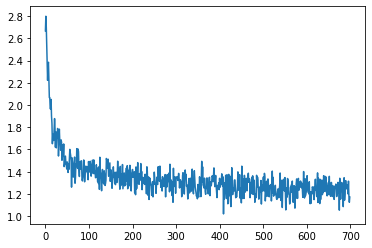

In [14]:
trainIters(encoder, attn_decoder, 70000, print_every=5000, learning_rate=0.01)
calculate_accuracy(encoder, attn_decoder, train_pairs)

#### Evaluation
Short query performance is bad because short sequence is common and contain less information.

In [15]:
_,_,test_pairs2 = get_city_pairs(df2_test) 
acc = calculate_accuracy(encoder, attn_decoder, test_pairs2)
_,_,test_pairs3 = get_city_pairs(df3_test) 
acc = calculate_accuracy(encoder, attn_decoder, test_pairs3)
_,_,test_pairs4 = get_city_pairs(df4_test) 
acc = calculate_accuracy(encoder, attn_decoder, test_pairs4)

Reading lines...
Read 2813 sentence pairs
Trimmed to 2775 sentence pairs
Counted words:
prev_city 113
next_city 117
Accuracy of 2775(2773): 16.77%
Reading lines...
Read 734 sentence pairs
Trimmed to 696 sentence pairs
Counted words:
prev_city 113
next_city 112
Accuracy of 696(694): 40.63%
Reading lines...
Read 231 sentence pairs
Trimmed to 193 sentence pairs
Counted words:
prev_city 111
next_city 96
Accuracy of 193(191): 44.50%


## Task 3
### Neural Machine Translation(with new data)
Add user information into previous system as new features, predict next city by translate user+city sequence to new city.

#### New data

In [16]:
def get_user_city_pairs(df_tar):
    with open('prev_user_city-next_city.txt','w') as f:
        for uid,date,country,city in zip(df_tar.user_id.to_list(),
                                         df_tar.joining_date.to_list(),
                                         df_tar.country.to_list(),
                                         df_tar.cities.to_list()):
            user_info = [str(uid),str(date),str(country)]       
            city_pair = city.split(', ')
            row = user_info + city_pair
            row = ' '.join(row[:-1])+'\t'+row[-1]+'\n'
            f.write(row)
    return prepareData('prev_user_city', 'next_city')

Add user information before sequence of city.

In [17]:
input_lang2, output_lang2, train_pairs2 = get_user_city_pairs(df2_train)
print('Random sample:',random.choice(train_pairs2))

Reading lines...
Read 6538 sentence pairs
Trimmed to 6089 sentence pairs
Counted words:
prev_user_city 3971
next_city 123
Random sample: ['4286 2015-03-31 UK Detroit MI', 'Windsor ON']


#### Same model

In [18]:
encoder2 = EncoderRNN(input_lang2.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang2.n_words, dropout_p=0.3).to(device)
set_global_variables(train_pairs2, input_lang2, output_lang2, encoder2, attn_decoder2)

True

2m 23s (left: 69m 14s) (5000 3%) 1.8355
4m 44s (left: 66m 17s) (10000 6%) 1.4664
7m 4s (left: 63m 37s) (15000 10%) 1.3896
9m 25s (left: 61m 16s) (20000 13%) 1.3347
11m 46s (left: 58m 50s) (25000 16%) 1.2902
14m 5s (left: 56m 22s) (30000 20%) 1.2301
16m 26s (left: 54m 0s) (35000 23%) 1.1716
18m 45s (left: 51m 36s) (40000 26%) 1.0984
21m 9s (left: 49m 23s) (45000 30%) 0.9821
23m 32s (left: 47m 5s) (50000 33%) 0.8960
25m 58s (left: 44m 51s) (55000 36%) 0.7854
28m 20s (left: 42m 31s) (60000 40%) 0.6910
30m 41s (left: 40m 8s) (65000 43%) 0.5999
33m 1s (left: 37m 44s) (70000 46%) 0.4711
35m 21s (left: 35m 21s) (75000 50%) 0.3999
37m 45s (left: 33m 2s) (80000 53%) 0.3538
40m 6s (left: 30m 40s) (85000 56%) 0.2497
42m 28s (left: 28m 19s) (90000 60%) 0.2301
44m 50s (left: 25m 57s) (95000 63%) 0.1750
47m 12s (left: 23m 36s) (100000 66%) 0.1389
49m 32s (left: 21m 13s) (105000 70%) 0.1150
51m 53s (left: 18m 52s) (110000 73%) 0.0856
54m 14s (left: 16m 30s) (115000 76%) 0.0949
56m 40s (left: 14m 10s)

<Figure size 432x288 with 0 Axes>

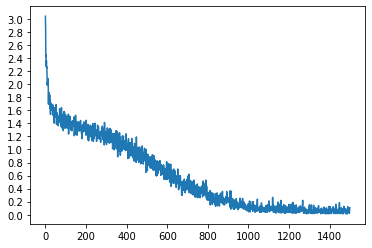

In [19]:
trainIters(encoder2, attn_decoder2, n_iters=150000, print_every=5000, learning_rate=0.01)
train_acc = calculate_accuracy(encoder2, attn_decoder2, train_pairs2)

Prediction accuracy is better especially for short sequence.

In [71]:
_,_,test_pairs2 = get_user_city_pairs(df2_test)
test_acc = calculate_accuracy(encoder2, attn_decoder2, test_pairs2)
_,_,test_pairs3 = get_user_city_pairs(df3_test)
test_acc = calculate_accuracy(encoder2, attn_decoder2, test_pairs3)
_,_,test_pairs4 = get_user_city_pairs(df4_test)
test_acc = calculate_accuracy(encoder2, attn_decoder2, test_pairs4)

Reading lines...
Read 2788 sentence pairs
Trimmed to 2622 sentence pairs
Counted words:
prev_user_city 2292
next_city 112
Accuracy of 2622(2301): 80.01%
Reading lines...
Read 718 sentence pairs
Trimmed to 552 sentence pairs
Counted words:
prev_user_city 676
next_city 108
Accuracy of 552(490): 85.10%
Reading lines...
Read 219 sentence pairs
Trimmed to 53 sentence pairs
Counted words:
prev_user_city 152
next_city 52
Accuracy of 53(46): 84.78%


#### New feature
Furthermore, the model can predict next city without any given cities, since we have user information now.

In [72]:
_,_,test_pairs1 = get_user_city_pairs(df1_test)
test_acc = calculate_accuracy(encoder2, attn_decoder2, test_pairs1)

Reading lines...
Read 6007 sentence pairs
Trimmed to 5841 sentence pairs
Counted words:
prev_user_city 3908
next_city 115
Accuracy of 5841(4317): 46.37%


#### Evaluation
This model is very fast with very high accuracy.

In [102]:
%time
set_global_variables(train_pairs2, input_lang2, output_lang2, encoder2, attn_decoder2)
evaluate_randomly(encoder2, attn_decoder2, test_pairs1, n=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
>>> 8770 2015-03-06 FR
  = Toronto ON
  > New York NY



In [113]:
evaluate_randomly(encoder2, attn_decoder2, test_pairs2, n=5)

>>> 6637 2015-03-31 UNK New York NY
  = Toronto ON
  > Newark NJ

>>> 8465 2015-03-22 IT OTTAWA ON Toronto ON
  = New York NY
  > New York NY

>>> 6810 2015-03-22 UK Philadelphia PA
  = Montreal QC
  > Montreal QC

>>> 9004 2015-03-18 UK Toronto ON
  = Oshawa ON
  > Oshawa ON

>>> 10260 2015-03-27 FR Philadelphia PA Newark NJ
  = New York NY
  > New York NY



>>> 3151 2015-03-23 ES San Diego CA New York NY
  = Los Angeles CA
  > Los Angeles CA


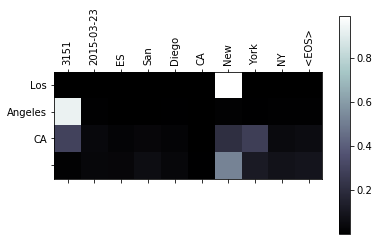

In [116]:
evaluate_and_show_attention(random.choice(test_pairs2))

## Task 4
Evaluation metrics for different models.

### 4.1 Frequent Itemset

#### Support and confidence
Use support to find frequent threshold, use condfidence to find assosiation rules.

### 4.2 Language Modeling

#### Perplexity
Train the model to minimize perplexity, use this metirc to evalute generated city sequence performance.

#### Accuracy
Use accuracy to evaluate the performance of the prediction of the last city.

### 4.3 Neural Machine Translation

#### Accuracy
Treat each city as a class, solve the classification problem using NMT.

#### *BLEU
If we train the model with variable input and output length, we could use BLEU(Bilingual Evaluation Understudy) score to eavaluate the model.

### 4.4 Others

#### ROC/PR curve
For other classification problems in task 1, we could use area under the curve to evaluate models.

#### Confusion matrix
For imblanced data, we can use CM to check recall rate of different classes.

#### Clustering evaluation
Visualize the embedding of high dimension data to see the cluster performance.

#### Time/Memory consumption
Sometimes we also need to take consideration of time/memory consumption of different models.